In [1]:
import os
import sys
import pickle
import numpy as np
from math import exp
from scipy import stats
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from vizsequence.viz_sequence import plot_weights_given_ax
from scipy.special import softmax
import keras
import keras.losses
from keras.models import Model, Sequential, load_model
from keras import backend as K
import numpy.random as rng
import seaborn as sns
from collections import OrderedDict
from basepair.losses import twochannel_multinomial_nll
import modisco
import modisco.tfmodisco_workflow.workflow
from modisco.tfmodisco_workflow import workflow
import h5py
import modisco.util
from collections import Counter
from modisco.visualization import viz_sequence
import modisco.affinitymat.core
import modisco.cluster.phenograph.core
import modisco.cluster.phenograph.cluster
import modisco.cluster.core
import modisco.aggregator
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

2020-08-04 10:30:38,413 [WARNING] From /users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

TF-MoDISco is using the TensorFlow backend.


In [2]:
all_post_hypimps = np.load("/users/amr1/pho4/data/imp-scores/pho4_pbexo/post_profile_hypimps.npy")
all_post_actualimps = np.load("/users/amr1/pho4/data/imp-scores/pho4_pbexo/post_profile_actualimps.npy")  
all_seqs = np.load("/users/amr1/pho4/data/imp-scores/pho4_pbexo/seqs.npy")

In [3]:
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=["pho4"],
                contrib_scores={"pho4": all_post_actualimps[0]},
                hypothetical_contribs={"pho4": all_post_hypimps[0]},
                one_hot=all_seqs)

grp = h5py.File("/users/amr1/pho4/data/modisco/pho4_pbexo/pho4_profile/results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

Untrimmed - sequence (scaled by information content)


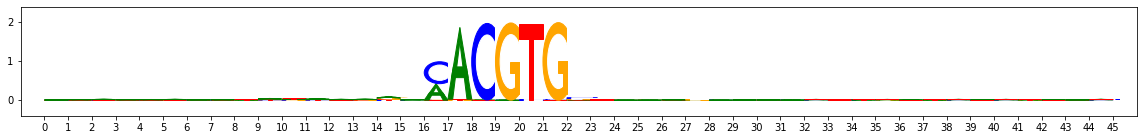

Untrimmed - task 0 hypothetical scores


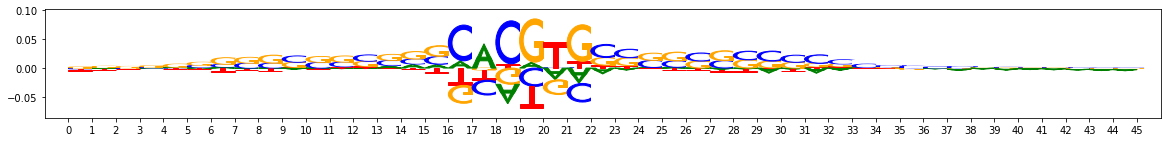

IC-trimmed - sequence (scaled by information content)


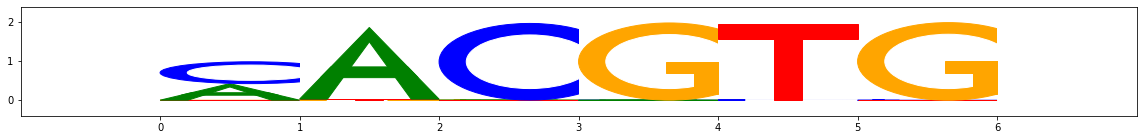

In [4]:
background = np.array([0.27, 0.23, 0.23, 0.27])
untrimmed_pattern = (
    loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_1"]
    .seqlets_to_patterns_result.patterns[0])
print("Untrimmed - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(untrimmed_pattern["sequence"].fwd, background=background))
print("Untrimmed - task 0 hypothetical scores")
viz_sequence.plot_weights(untrimmed_pattern["pho4_hypothetical_contribs"].fwd)
trimmed = untrimmed_pattern.trim_by_ic(ppm_track_name="sequence", background=background, threshold=0.3)
print("IC-trimmed - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(trimmed["sequence"].fwd, background=background))

In [5]:
print(trimmed["pho4_hypothetical_contribs"].fwd)

[[ 0.01255471  0.06181628 -0.030888   -0.02996561]
 [ 0.04187305 -0.02560904 -0.00352774 -0.01742064]
 [-0.03367965  0.07425042 -0.02806126  0.00739315]
 [ 0.01024079 -0.03169863  0.07470668 -0.03731555]
 [-0.02005992 -0.00021487 -0.02552471  0.04485511]
 [-0.02663652 -0.03215931  0.0630985   0.01159291]]


In [6]:
imp_scores = all_post_actualimps[0]
onehot_seq = np.array(all_seqs)
fwd_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed["pho4_hypothetical_contribs"].fwd)
rev_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed["pho4_hypothetical_contribs"].rev)

#We take the max of the masked_cosine_sim on the fwd and reverse strands
is_fwd_masked_cosine_sim = fwd_masked_cosine_sim > rev_masked_cosine_sim
masked_cosine_sim = (fwd_masked_cosine_sim*is_fwd_masked_cosine_sim
                     + rev_masked_cosine_sim*(is_fwd_masked_cosine_sim==False))

#Also look at the total sum of scores in each window
sum_scores = modisco.util.compute_sum_scores(imp_scores=imp_scores,
                                             window_size=len(trimmed["pho4_hypothetical_contribs"].fwd))

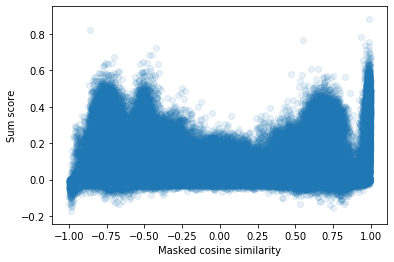

In [7]:
plt.scatter(masked_cosine_sim.ravel(), sum_scores.ravel(), alpha=0.1)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.show()

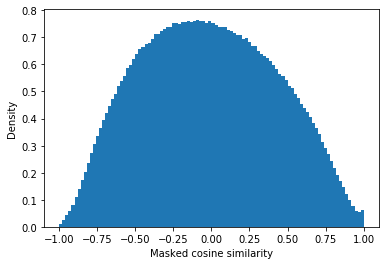

In [8]:
plt.hist(masked_cosine_sim.ravel(), bins=100, density=True)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Density")
plt.show()

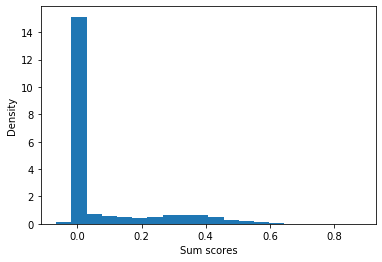

In [9]:
masked_cosine_sim_thresh = 0.9
plt.hist(sum_scores.ravel()[masked_cosine_sim.ravel() > masked_cosine_sim_thresh],
         bins=20, density=True)
plt.xlabel("Sum scores")
plt.ylabel("Density")
plt.show()

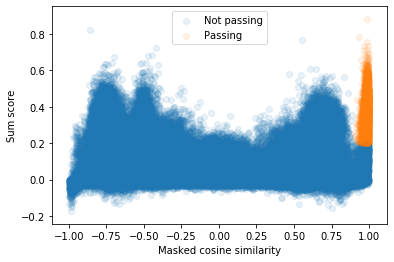

In [10]:
sum_score_thresh = 0.2
threshold_passers = ((masked_cosine_sim > masked_cosine_sim_thresh)*
                     (sum_scores > sum_score_thresh))
handles = []
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers==False].ravel(),
            sum_scores[threshold_passers==False].ravel(), alpha=0.1))
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers].ravel(),
            sum_scores[threshold_passers].ravel(), alpha=0.1))
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.legend(handles=handles, labels=["Not passing", "Passing"])
plt.show()

cosine similarity: 0.99382714822088 sum scores: 0.265861067379592


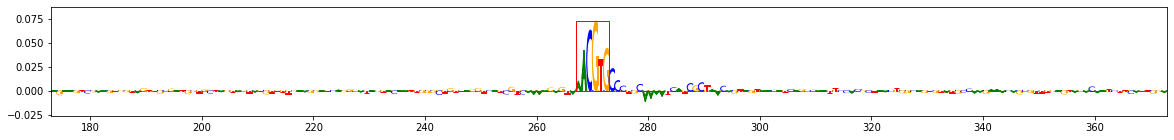

cosine similarity: 0.9940844782626337 sum scores: 0.4244072190558654


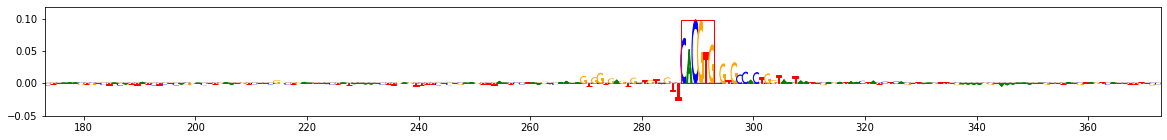

cosine similarity: 0.9881454188532218 sum scores: 0.3267741113508237


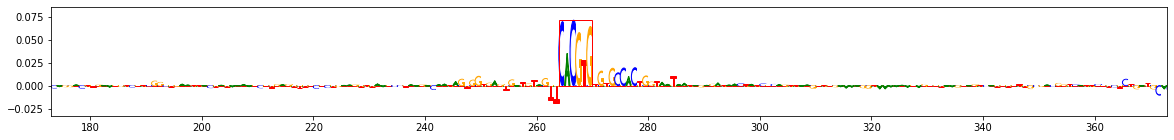

cosine similarity: 0.9887677478319572 sum scores: 0.22424502538706292


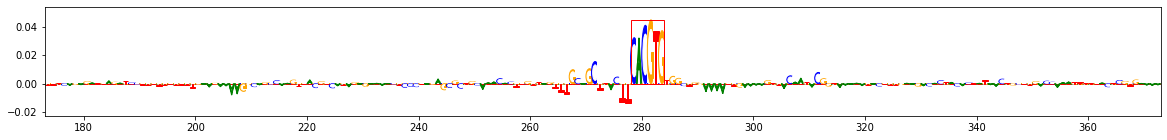

cosine similarity: 0.9614573131749624 sum scores: 0.36179899275302885


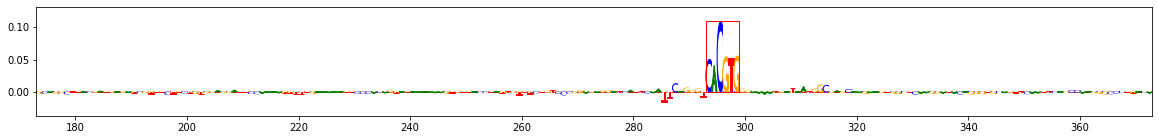

In [11]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
num_to_viz = 5
for (seq_idx, hit_pos) in hit_locations[:num_to_viz]:
    print("cosine similarity:", masked_cosine_sim[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)     
    viz_sequence.plot_weights_given_ax(ax=ax,
        array=imp_scores[seq_idx],
        height_padding_factor=0.2,
        length_padding=1.0,
        highlight={'red': [(hit_pos, hit_pos+len(trimmed))]},
        subticks_frequency=20)
    plt.xlim((173,373))
    plt.show()

logodds pwm score: 7.887958849083627 sum scores: 0.19374577599082843


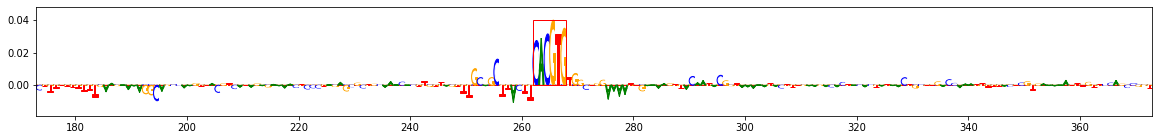

logodds pwm score: 7.887958849083627 sum scores: -0.017807829374032736


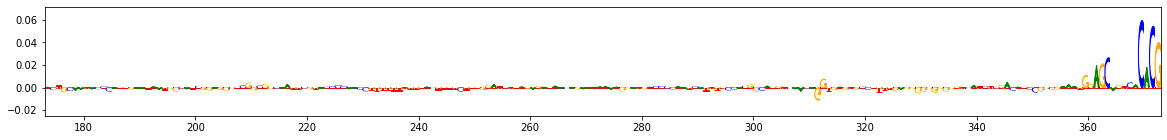

logodds pwm score: 7.887958849083627 sum scores: 0.10167072046751854


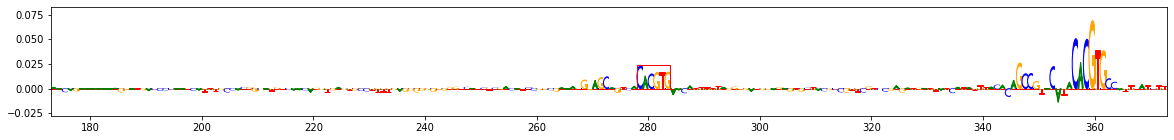

logodds pwm score: 7.887958849083627 sum scores: 0.08614866647694724


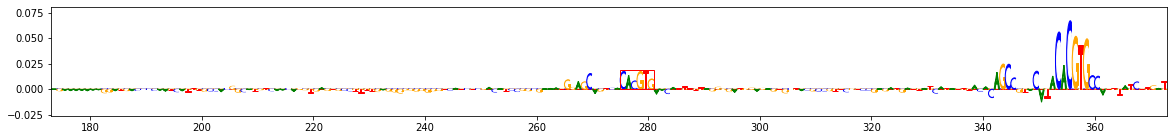

logodds pwm score: 7.887958849083627 sum scores: 0.0272942661504203


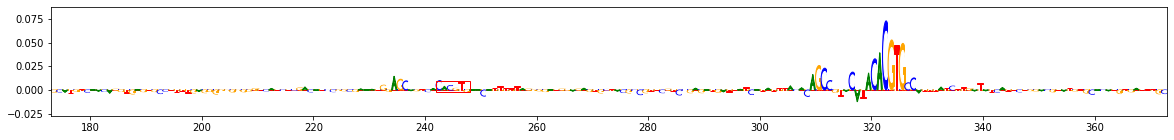

In [13]:
#To compute scores from a simple log-odds pwm scan, we can use the code below
# Note that because the simulation was generated using a position probability matrix (ppm), the scanning
# with the log-odds pwm works better than the masked cosine similarity.
#However, in-vivo TF binding is more complex than what can be characterized by a log-odds pwm - 
# see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3936734/
logodds_pwm = modisco.util.get_logodds_pwm(ppm=trimmed["sequence"].fwd,
                                           background=background, pseudocount=0.001)
#For simplicity, we will only compute the scores for the forward version of the
# motif since that was what was used in the simulation.
fwd_logodds_pwm_scores = modisco.util.compute_pwm_scan(onehot_seq=onehot_seq,
                                                       weightmat=logodds_pwm)
lower_imp_hit_locations = list(zip(*np.nonzero((fwd_logodds_pwm_scores > 7.85)
                                            *(sum_scores < sum_score_thresh))))
for (seq_idx, hit_pos) in lower_imp_hit_locations[:num_to_viz]:
    print("logodds pwm score:", fwd_logodds_pwm_scores[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)     
    viz_sequence.plot_weights_given_ax(ax=ax,
        array=imp_scores[seq_idx],
        height_padding_factor=0.2,
        length_padding=1.0,
        highlight={'red': [(hit_pos, hit_pos+len(trimmed))]},
        subticks_frequency=20)
    plt.xlim((173,373))
    plt.show()